In [1]:
!pip install -qq pyspark matplotlib
import os
from pyspark.sql import SparkSession

In [2]:
# Set the target directory to '../data' relative to the notebook
data_dir = "../data"
os.makedirs(data_dir, exist_ok=True)

# Base URL for the 10BT Sample
base_url = "https://huggingface.co/datasets/HuggingFaceFW/fineweb-edu/resolve/main/sample/10BT"

# Loop through files 000 to 013
for i in range(14):
    filename = f"{i:03d}_00000.parquet"
    save_path = os.path.join(data_dir, filename)
    
    # Only download if missing
    if not os.path.exists(save_path):
        print(f"Downloading {filename}...")
        !wget -q -O {save_path} {base_url}/{filename}
    else:
        print(f"Skipping {filename} (Already exists)")

print("All 14 sample files downloaded.")

Skipping 000_00000.parquet (Already exists)
Skipping 001_00000.parquet (Already exists)
Skipping 002_00000.parquet (Already exists)
Skipping 003_00000.parquet (Already exists)
Skipping 004_00000.parquet (Already exists)
Skipping 005_00000.parquet (Already exists)
Skipping 006_00000.parquet (Already exists)
Skipping 007_00000.parquet (Already exists)
Skipping 008_00000.parquet (Already exists)
Skipping 009_00000.parquet (Already exists)
Skipping 010_00000.parquet (Already exists)
Skipping 011_00000.parquet (Already exists)
Skipping 012_00000.parquet (Already exists)
Skipping 013_00000.parquet (Already exists)
All 14 sample files downloaded.


In [3]:
# Create SparkSession with specified configurations

# Driver memory = 1 - 2GB (fixed, small) => 2
# Executor memory = (Total Memory - Driver Memory) / Executor Instances => floor((128 - 2) / 7) = 18
# Executor instances = Total Cores - 1 => 8 - 1 = 7

# Adjusted executor memory to 15g to ensure we stay within the total memory limit while allowing for overhead and other processes.

spark = SparkSession.builder \
    .config("spark.driver.memory", "2g") \
    .config("spark.executor.memory", "15g") \
    .config("spark.executor.instances", 7) \
    .getOrCreate()

spark

In [4]:
# Read all parquet files from the '../data' directory into a single DataFrame
df = spark.read.parquet("../data")

In [5]:
# Show the schema of the DataFrame to verify it loaded correctly
df.printSchema()

root
 |-- text: string (nullable = true)
 |-- id: string (nullable = true)
 |-- dump: string (nullable = true)
 |-- url: string (nullable = true)
 |-- file_path: string (nullable = true)
 |-- language: string (nullable = true)
 |-- language_score: double (nullable = true)
 |-- token_count: long (nullable = true)
 |-- score: double (nullable = true)
 |-- int_score: long (nullable = true)



In [6]:
%%time
# Total number of rows
print(f"Total rows: {df.count():,}")

Total rows: 9,672,101
CPU times: user 1.41 ms, sys: 176 µs, total: 1.58 ms
Wall time: 2.96 s


In [7]:
%%time
# How many partitions Spark created (affects parallelism)
print(f"Number of partitions: {df.rdd.getNumPartitions()}")

Number of partitions: 213
CPU times: user 1.66 ms, sys: 688 µs, total: 2.35 ms
Wall time: 100 ms


In [8]:
# Show what rows look like and substring(text, 1, 200) shows only the first 200 chars to keep output readable.

from pyspark.sql import functions as F

df.select(
    "id",
    "language",
    "language_score",
    "token_count",
    "score",
    "int_score",
    F.substring("text", 1, 200).alias("text_preview")
).show(5, truncate=False)


+-----------------------------------------------+--------+------------------+-----------+--------+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id                                             |language|language_score    |token_count|score   |int_score|text_preview                                                                                                                                                                                               |
+-----------------------------------------------+--------+------------------+-----------+--------+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|<urn:uuid:8ffa5796-ad29-4108-ba38-feb25750ec0b>|en      |0.9

In [9]:
# Count nulls per column to check missingness
null_counts = df.select([
    F.sum(F.col(c).isNull().cast("int")).alias(c)
    for c in df.columns
])
null_counts.show(truncate=False)

# Specifically check empty text rows (null or length 0)
df.select(
    F.sum((F.col("text").isNull() | (F.length("text") == 0)).cast("int")).alias("empty_text_rows")
).show()


+----+---+----+---+---------+--------+--------------+-----------+-----+---------+
|text|id |dump|url|file_path|language|language_score|token_count|score|int_score|
+----+---+----+---+---------+--------+--------------+-----------+-----+---------+
|0   |0  |0   |0  |0        |0       |0             |0          |0    |0        |
+----+---+----+---+---------+--------+--------------+-----------+-----+---------+

+---------------+
|empty_text_rows|
+---------------+
|              0|
+---------------+



In [10]:
# token_count summary: shows scale and skew (min/median/mean/max)
df.select(
    F.min("token_count").alias("min_tokens"),
    F.expr("percentile_approx(token_count, 0.5)").alias("median_tokens"),
    F.mean("token_count").alias("mean_tokens"),
    F.max("token_count").alias("max_tokens")
).show()

# score summary: range and central tendency
df.select(
    F.min("score").alias("min_score"),
    F.expr("percentile_approx(score, 0.5)").alias("median_score"),
    F.mean("score").alias("mean_score"),
    F.max("score").alias("max_score")
).show()


+----------+-------------+------------------+----------+
|min_tokens|median_tokens|       mean_tokens|max_tokens|
+----------+-------------+------------------+----------+
|        42|          629|1031.1015338859675|    170927|
+----------+-------------+------------------+----------+

+---------+------------+-----------------+---------+
|min_score|median_score|       mean_score|max_score|
+---------+------------+-----------------+---------+
| 2.515625|     2.90625|3.006352990485211|  5.34375|
+---------+------------+-----------------+---------+



Matplotlib created a temporary cache directory at /scratch/jchanthabandith/job_46593909/matplotlib-joe0cqn2 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


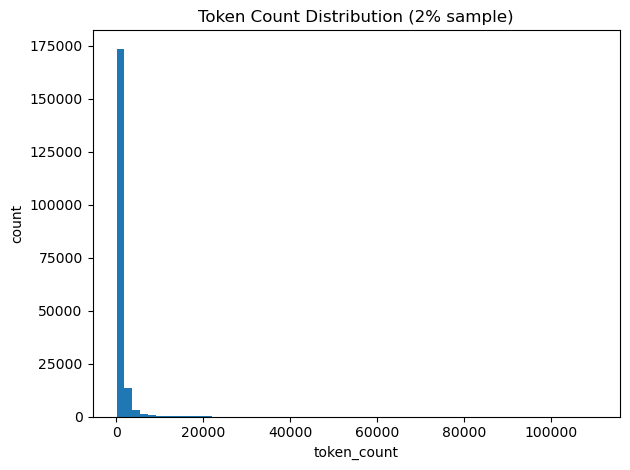

In [11]:
# Convert a small random sample to pandas for plotting with matplotlib.
import matplotlib.pyplot as plt


sample_tokens = (df.select("token_count")
                   .where(F.col("token_count").isNotNull())
                   .sample(False, 0.02, seed=42)   # 2% sample
                   .toPandas())

plt.figure()
plt.hist(sample_tokens["token_count"], bins=60)
plt.title("Token Count Distribution (2% sample)")
plt.xlabel("token_count")
plt.ylabel("count")
plt.tight_layout()
plt.show()


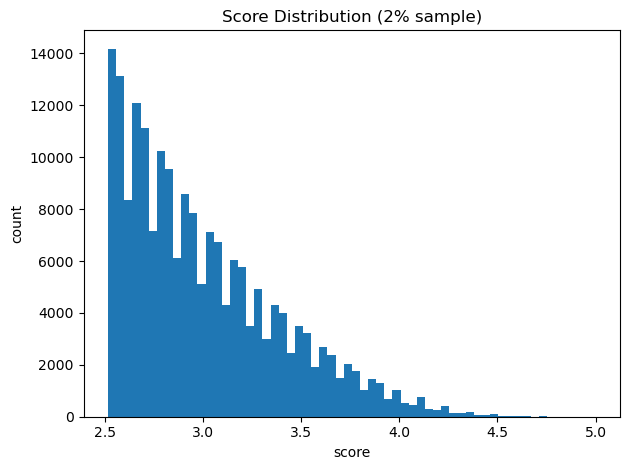

In [12]:
# Plot distribution of educational quality score
sample_scores = (df.select("score")
                   .where(F.col("score").isNotNull())
                   .sample(False, 0.02, seed=42)   # 2% sample
                   .toPandas())

plt.figure()
plt.hist(sample_scores["score"], bins=60)
plt.title("Score Distribution (2% sample)")
plt.xlabel("score")
plt.ylabel("count")
plt.tight_layout()
plt.show()


In [13]:
# Preprocessing idea:
# - remove null text
# - remove extremely short documents
# - enforce minimum token_count
# - dedupe by id
clean_df = (df
    .filter(F.col("text").isNotNull())
    .filter(F.length("text") > 200)
    .filter(F.col("token_count") >= 50)
    .dropDuplicates(["id"])
)

print("Rows before cleaning:", df.count())
print("Rows after cleaning:", clean_df.count())


Rows before cleaning: 9672101
Rows after cleaning: 9672072
